In [118]:
import collections
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [194]:
data = pd.read_csv('../data/twitter_sentiment_analysis_data_raw.csv', encoding='latin-1', names=['label', 'id', 'data', 'query', 'author', 'tweet'])

In [195]:
data.loc[data['label']==4, 'label'] = 1
data.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [108]:
data.head()

,label,id,data,query,author,tweet,adjusted_tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",- a thats a bummer you shoulda got david ca...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behav at all im mad why am i here ...


In [157]:
train.head()

,label,id,data,query,author,tweet,adjusted_tweets
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be working tomorrow, and then I called the agency to follow up and they said it was over.",look like i'v miss out on yet anoth job someon pleas employ me! haha
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see you tomorrow for the night.,lose time
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in Inventor. Good times.",NaN
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,"Had a great lunch with one of my &quot;mums&quot; today, @christineirmler It's her birthday tomorrow too so I got her a little something",NaN
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/KoqAbg,NaN


In [162]:
train.head()

,label,id,data,query,author,tweet,adjusted_tweets,adjusted_tweet
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be working tomorrow, and then I called the agency to follow up and they said it was over.",look like i'v miss out on yet anoth job someon pleas employ me! haha,notice told tomorrow called agency follow
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see you tomorrow for the night.,lose time,sleep hate bye tomorrow night
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in Inventor. Good times.",NaN,ahh tedium broken file links inventor times
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,"Had a great lunch with one of my &quot;mums&quot; today, @christineirmler It's her birthday tomorrow too so I got her a little something",NaN,lunch mums birthday tomorrow someth
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/KoqAbg,NaN,john muir dr


In [174]:
def adjust_tweet(sentence):
    re_punctuations = r""",|'|\.|!|\?|&|"|:|[|]|;|quot|\\/|ing|\\(|\\)|http\S+|www\S+|@\S+|.com\S+|-|_|=|\+"""
    words_list = re.sub(re_punctuations, "", sentence.lower()).split()
    adjusted_words_list = [
        word for word in words_list
        if len(word) > 1 and re.sub(re_punctuations,'', word) not in stop_words
    ]
    return ' '.join(adjusted_words_list)

# Sampled data

In [123]:
df = data.groupby('label').head(1250).reset_index(drop=True)

In [175]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

In [176]:
def txt_to_list(file_name):
    my_file = open(file_name, "r", encoding="utf8")
    content_list = [line.rstrip('\n') for line in my_file.readlines()]
    return content_list

def build_vocabularies(data, label_col, sentence_col):
    pos_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==1, sentence_col].values.tolist() 
        for word in tweet.split(' ') 
    ]
    
    neg_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==0, sentence_col].values.tolist() 
        for word in tweet.split(' ') 
    ]

    return pos_vocabulary, neg_vocabulary    

In [180]:
train['adjusted_tweet'] = train['tweet'].apply(adjust_tweet)
test['adjusted_tweet'] = test['tweet'].apply(adjust_tweet)

pos_vocabulary, neg_vocabulary = build_vocabularies(train, 'label', 'adjusted_tweet')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

In [181]:
# all_vocabulary = (neg_freq + pos_freq).keys()

def build_vocabulary(pos_freq=pos_freq, neg_freq=neg_freq):
    df_pos = pd.DataFrame([(k, v) for k, v in pos_freq.items()], columns=['word', 'pos_count'])
    df_neg = pd.DataFrame([(k, v) for k, v in neg_freq.items()], columns=['word', 'neg_count'])
    df_vocabulary = pd.merge(df_pos, df_neg, on='word', how='outer').fillna(0)
    
    df_vocabulary['p_pos'] = (df_vocabulary['pos_count'] + 1) / (df_pos.shape[0] + df_vocabulary.shape[0])
    df_vocabulary['p_neg'] = (df_vocabulary['neg_count'] + 1) / (df_pos.shape[0] + df_vocabulary.shape[0])
    
    df_vocabulary['ratio'] = df_vocabulary['p_pos'] / df_vocabulary['p_neg']
    df_vocabulary['lambda'] = np.log2(df_vocabulary['ratio'])
    
    return df_vocabulary

df_vocabulary = build_vocabulary()
df_vocabulary.loc[df_vocabulary['pos_count'] == 0].head(15)

,word,pos_count,neg_count,p_pos,p_neg,ratio,lambda
1514,agency,0.0,2.0,0.000249,0.000747,0.333333,-1.584963
1515,bye,0.0,1.0,0.000249,0.000498,0.500000,-1.000000
1516,john,0.0,1.0,0.000249,0.000498,0.500000,-1.000000
1517,muir,0.0,1.0,0.000249,0.000498,0.500000,-1.000000
1518,sucks,0.0,2.0,0.000249,0.000747,0.333333,-1.584963
1519,xbox,0.0,1.0,0.000249,0.000498,0.500000,-1.000000
1520,360,0.0,1.0,0.000249,0.000498,0.500000,-1.000000
1521,fancast,0.0,1.0,0.000249,0.000498,0.500000,-1.000000
1522,tonite,0.0,2.0,0.000249,0.000747,0.333333,-1.584963
1523,favenot,0.0,1.0,0.000249,0.000498,0.500000,-1.000000


In [182]:
train.head()

,label,id,data,query,author,tweet,adjusted_tweet
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be working tomorrow, and then I called the agency to follow up and they said it was over.",notice told id work tomorrow called agency follow said
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see you tomorrow for the night.,sleep soon hate say bye see tomorrow night
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in Inventor. Good times.",ahh tedium fix broken file links inventor good times
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,"Had a great lunch with one of my &quot;mums&quot; today, @christineirmler It's her birthday tomorrow too so I got her a little something",great lunch one mums today birthday tomorrow got little someth
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/KoqAbg,back work john muir dr


In [183]:
def calculate_scores(sentence, df_vocabulary = df_vocabulary):
    words_list = sentence.split(' ')
    score = 0
    for word in words_list:
        value = df_vocabulary.loc[df_vocabulary['word'] == word, 'lambda']
        score += list(df_vocabulary.loc[df_vocabulary['word'] == word, 'lambda'])[0] if len(value) > 0 else 0
    return score

In [185]:
train['score'] = train["adjusted_tweet"].map(calculate_scores).tolist()
train['pred'] = (train['score'] > 0).astype(int)

In [187]:
test['score'] = test["adjusted_tweet"].map(calculate_scores).tolist()
test['pred'] = (test['score'] > 0).astype(int)

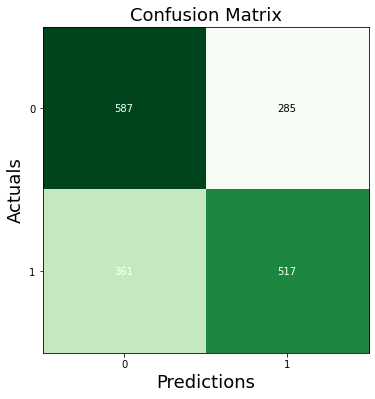

In [188]:
conf_mat = confusion_matrix(test['label'], test['pred'])
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [189]:
logreg=accuracy_score(test['label'], test['pred'])
logreg

0.6308571428571429

In [190]:
roc_auc_score(test['label'], test['pred'])

0.6310017032036948

In [191]:
print(metrics.classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65       872
           1       0.64      0.59      0.62       878

    accuracy                           0.63      1750
   macro avg       0.63      0.63      0.63      1750
weighted avg       0.63      0.63      0.63      1750



# Using all data

In [196]:
df = data
df.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [197]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

train['adjusted_tweet'] = train['tweet'].apply(adjust_tweet)
test['adjusted_tweet'] = test['tweet'].apply(adjust_tweet)

pos_vocabulary, neg_vocabulary = build_vocabularies(train, 'label', 'adjusted_tweet')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

In [199]:
# test['score'] = test["adjusted_tweet"].map(calculate_scores).tolist()
test['score'] = test['adjusted_tweet'].apply(calculate_scores)
test['pred'] = (test['score'] > 0).astype(int)

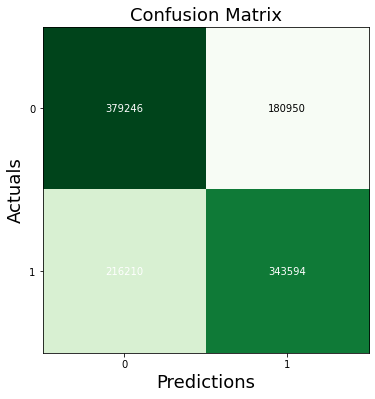

In [200]:
conf_mat = confusion_matrix(test['label'], test['pred'])
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [201]:
logreg=accuracy_score(test['label'], test['pred'])
logreg

0.6453928571428571

In [202]:
roc_auc_score(test['label'], test['pred'])

0.645381794952127

In [203]:
print(metrics.classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66    560196
           1       0.66      0.61      0.63    559804

    accuracy                           0.65   1120000
   macro avg       0.65      0.65      0.65   1120000
weighted avg       0.65      0.65      0.65   1120000

